# Shoplifting Video Classification using ConvLSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/shop dataSet.zip" -d "/content"

Archive:  /content/drive/MyDrive/shop dataSet.zip
   creating: /content/Shop DataSet/non shop lifters/
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_1_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_10.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_10_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_100.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_100_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_101.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_101_1.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lifter_n_102.mp4  
  inflating: /content/Shop DataSet/non shop lifters/shop_lift

### Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import cv2
import random
from sklearn import metrics
from sklearn.classifier_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.classifiers import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": False})


### random seed for reproducibility

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Dataset Exploration

In [5]:
DATASET_DIR = "/content/Shop DataSet"
shop_lifters_dir = os.path.join(DATASET_DIR, "shop lifters")
non_shop_lifters_dir = os.path.join(DATASET_DIR, "non shop lifters")

#print the number of video files in each directory
print(f"Found {len(os.listdir(shop_lifters_dir))} video files in the directory: {shop_lifters_dir}")
print(f"Found {len(os.listdir(non_shop_lifters_dir))} video files in the directory: {non_shop_lifters_dir}")

Found 324 video files in the directory: /content/Shop DataSet/shop lifters
Found 531 video files in the directory: /content/Shop DataSet/non shop lifters


In [6]:
#inspect a few samples
def inspect_samples(video_dir):
    for video_file in os.listdir(video_dir)[:10]:
        cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        print(f"Video: {video_file}, Width: {frame_width}, Height: {frame_height}, FPS: {frame_rate}, Frames: {frame_count}")


In [7]:
inspect_samples(shop_lifters_dir) #shop lifters directory

Video: shop_lifter_46.mp4, Width: 704, Height: 576, FPS: 24, Frames: 322
Video: videyyyyyynnnnnnzzzzzyyyss_8.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300
Video: shop_lifter_54.mp4, Width: 704, Height: 576, FPS: 24, Frames: 297
Video: videyyyyyyyyyss_59.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300
Video: videmmmmmmsss_97.mp4, Width: 704, Height: 576, FPS: 24, Frames: 223
Video: shop_lifter_64.mp4, Width: 704, Height: 576, FPS: 24, Frames: 273
Video: videyyyyyynnnnnnzzzzzyyyss_6.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300
Video: videppppsss_55.mp4, Width: 704, Height: 576, FPS: 25, Frames: 150
Video: shop_lifter_93.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: videyyyyyyyyyss_62.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300


In [8]:
inspect_samples(non_shop_lifters_dir) #non shop lifters directory

Video: shop_lifter_n_175.mp4, Width: 704, Height: 576, FPS: 25, Frames: 450
Video: shop_lifter_n_156.mp4, Width: 704, Height: 576, FPS: 25, Frames: 200
Video: shop_lifter_n_166.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_n_177.mp4, Width: 704, Height: 576, FPS: 25, Frames: 425
Video: shop_lifter_n_176_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_n_27.mp4, Width: 704, Height: 576, FPS: 25, Frames: 200
Video: shop_lifter_n_120_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 250
Video: shop_lifter_n_23_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 350
Video: shop_lifter_n_159.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_n_70_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375


### Dataset Preprocessing and preparation

In [9]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64 # height and width to which each video frame will be resized in our dataset.

SEQUENCE_LENGTH = 20 # number of frames of a video that will be fed to the classifier as one sequence.

CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])
print(CLASSES_LIST)

['non shop lifters', 'shop lifters']


In [10]:
def frames_extraction(video_path):

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list


In [11]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [12]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non shop lifters
Extracting Data of Class: shop lifters


In [13]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [14]:
#Split the Data into 70% for training, 15% for validation and 15% for testing

train_features, temp_features, train_labels, temp_labels = train_test_split(
    features, labels, test_size=0.3, shuffle=True, random_state=seed_constant
)

val_features, test_features, val_labels, test_labels = train_test_split(
    temp_features, temp_labels, test_size=0.5, shuffle=False, random_state=seed_constant
)

print(f"num of training samples: {len(train_features)} , and the shape is {train_features.shape}")
print(f"num of validation samples: {len(val_features)} , and the shape is {val_features.shape}")
print(f"num of test samples: {len(test_features)} , and the shape is {test_features.shape}")

num of training samples: 598 , and the shape is (598, 20, 64, 64, 3)
num of validation samples: 128 , and the shape is (128, 20, 64, 64, 3)
num of test samples: 129 , and the shape is (129, 20, 64, 64, 3)


### ConvLSTM Model Architecture and Training

In [16]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, Dropout, Flatten, Dense, TimeDistributed

#classifier architecture
def create_convlstm_classifier():

    classifier = Sequential()

    classifier.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.1, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    classifier.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    classifier.add(TimeDistributed(Dropout(0.1)))

    classifier.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    classifier.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    classifier.add(TimeDistributed(Dropout(0.1)))

    classifier.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.1, return_sequences=True))

    classifier.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    classifier.add(TimeDistributed(Dropout(0.1)))

    classifier.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.1, return_sequences=True))

    classifier.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    classifier.add(Flatten())

    classifier.add(Dense(1, activation= "sigmoid"))

    # Return the constructed convlstm classifier.
    return classifier

In [17]:
classifier= create_convlstm_classifier()
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,881 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,881 (140.16 KB)

 Trainable params: 35,881 (140.16 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras.metrics import Precision, Recall

classifier.compile( optimizer='adam', loss='binary_crossentropy', metrics=['performance_score', Precision(), Recall()])


In [19]:
# ModelCheckpoint: Save the classifier after every epoch.
checkpoint = ModelCheckpoint(
    'shoplifting.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [20]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [21]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [22]:
history = classifier.fit(
    x=train_features, y=train_labels, epochs=20, batch_size= 4, validation_data=(val_features, val_labels),
    callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau]
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 345ms/step - accuracy: 0.5522 - loss: 0.6941 - precision: 0.4397 - recall: 0.1644 - val_accuracy: 0.6484 - val_loss: 0.6466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step - accuracy: 0.5731 - loss: 0.6826 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6484 - val_loss: 0.6172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7277 - loss: 0.5491 - precision: 0.7176 - recall: 0.5081 - val_accuracy: 0.8828 - val_loss: 0.2873 - val_precision: 0.8000 - val_recall: 0.8889 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8928 - loss: 0.2468 - precision: 0.8803 - recall: 0.8670 - val_accuracy: 0.9688 - val_loss: 0.0913 - val_precision: 1.0000 - val_recall: 0.9111 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━

In [23]:
val_loss, val_performance_score, val_precision, val_recall = classifier.evaluate(val_features, val_labels)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_performance_score)
print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 1.0000 - loss: 0.0038 - precision: 1.0000 - recall: 1.0000
Validation Loss: 0.0022252697963267565
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0


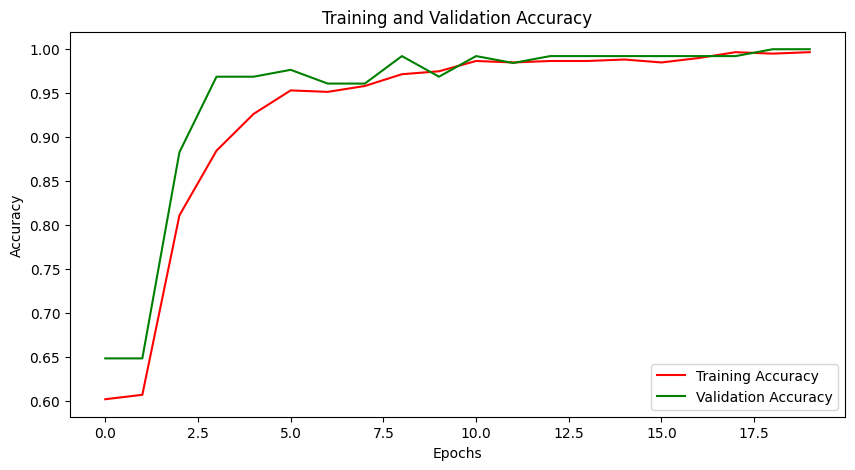

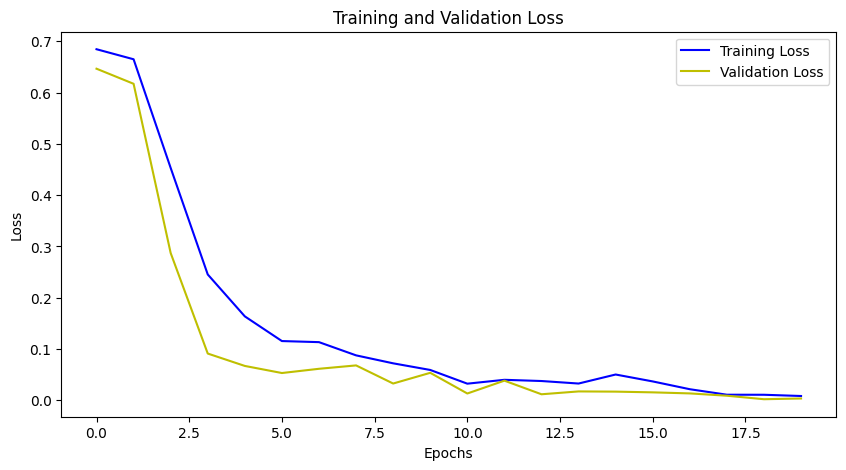

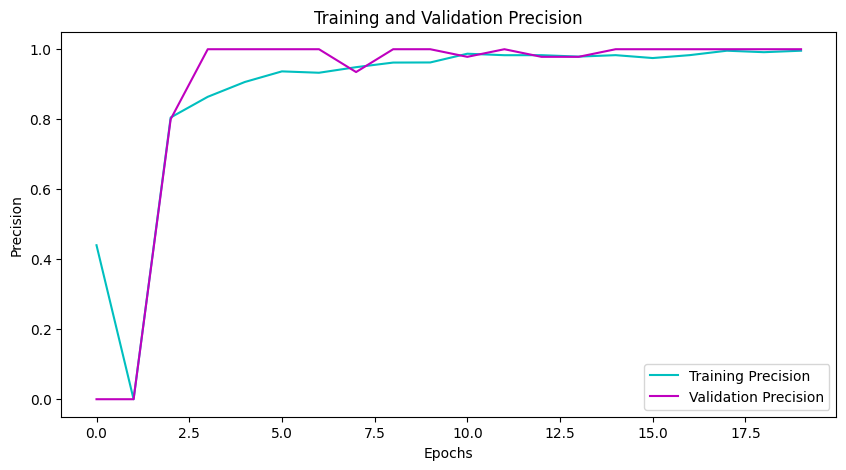

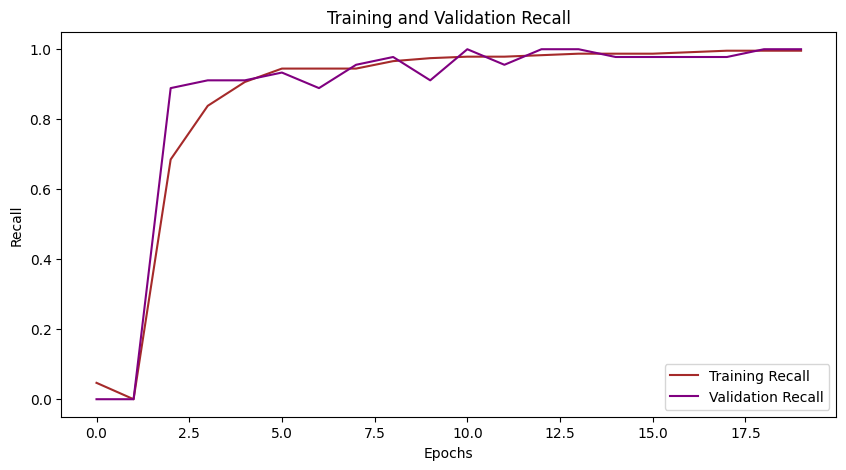

In [24]:
# Function to plot performance_score, loss, precision, and recall
def plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, precision, 'c', label='Training Precision')
    plt.plot(epochs, val_precision, 'm', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, recall, 'brown', label='Training Recall')
    plt.plot(epochs, val_recall, 'purple', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(loc=0)
    plt.show()


# Extracting history values
classifier_history = history.history

acc = classifier_history['performance_score']
val_acc = classifier_history['val_performance_score']
loss = classifier_history['loss']
val_loss = classifier_history['val_loss']
precision = classifier_history['precision']
val_precision = classifier_history['val_precision']
recall = classifier_history['recall']
val_recall = classifier_history['val_recall']

epochs = history.epoch

# Call the updated function
plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs)


In [25]:
classifier.save('convLSTM_shoplifting_classifier.h5')

### Model Evaluation

In [26]:
#load classifier
from tensorflow.keras.classifiers import load_classifier
classifier = load_classifier('convLSTM_shoplifting_classifier.h5', compile= False)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 907ms/step


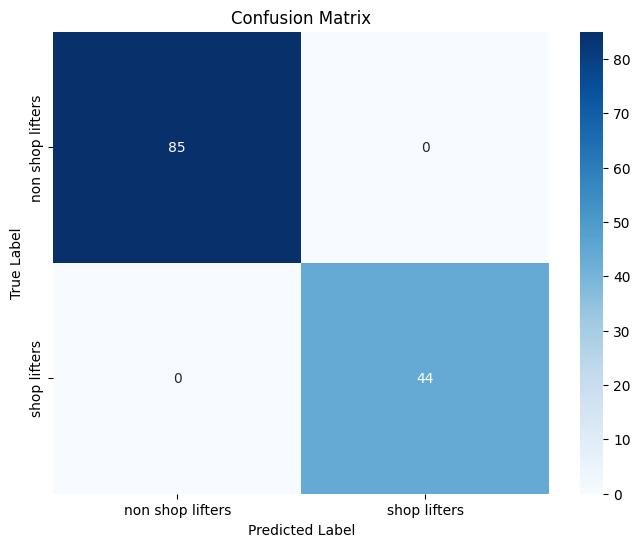

                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        85
    shop lifters       1.00      1.00      1.00        44

        accuracy                           1.00       129
       macro avg       1.00      1.00      1.00       129
    weighted avg       1.00      1.00      1.00       129



In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.classifiers import load_classifier

# Load the classifier
classifier = load_classifier('convLSTM_shoplifting_classifier.h5')

# Get true labels and output_predictions
y_pred_probs = classifier.predict(test_features)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification
y_true = test_labels  # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["non shop lifters", "shop lifters"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


### trying different hyperparameters

In [29]:
convlstm_classifier= create_convlstm_classifier()

In [30]:
convlstm_classifier.compile( optimizer='adam', loss='binary_crossentropy', metrics=['performance_score', Precision(), Recall()])

In [32]:
history = convlstm_classifier.fit(
    x=train_features, y=train_labels, epochs=20, batch_size= 8, validation_data=(val_features, val_labels),
    callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 721ms/step - accuracy: 0.5614 - loss: 0.6816 - precision_1: 0.4405 - recall_1: 0.1174 - val_accuracy: 0.6641 - val_loss: 0.5020 - val_precision_1: 0.5833 - val_recall_1: 0.1556 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.7781 - loss: 0.4404 - precision_1: 0.7748 - recall_1: 0.6620 - val_accuracy: 0.8750 - val_loss: 0.2668 - val_precision_1: 0.7843 - val_recall_1: 0.8889 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8924 - loss: 0.2569 - precision_1: 0.8703 - recall_1: 0.8787 - val_accuracy: 0.9609 - val_loss: 0.1294 - val_precision_1: 0.9348 - val_recall_1: 0.9556 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9017 - loss: 0.2244 - precision_1: 0.8727 - recall_1: 0.9006 - val_accuracy: 0.9688 - val_loss: 0.1039 - val_precision_1: 1.0000 - val_recall_1: 0.9111 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━

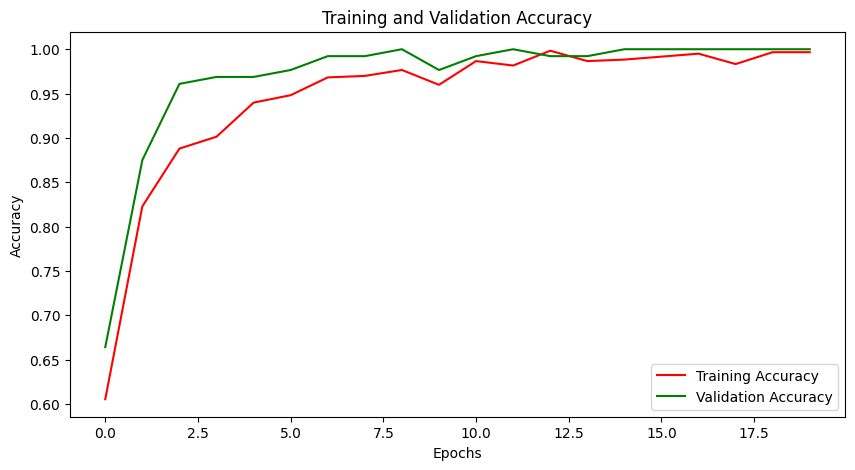

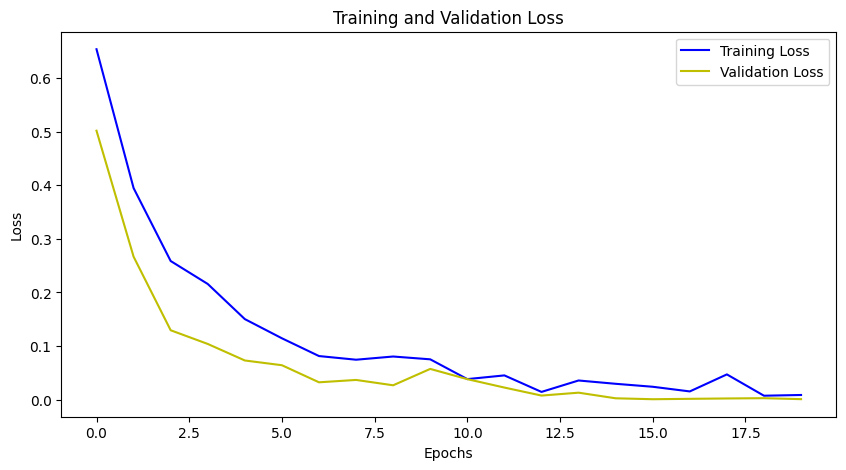

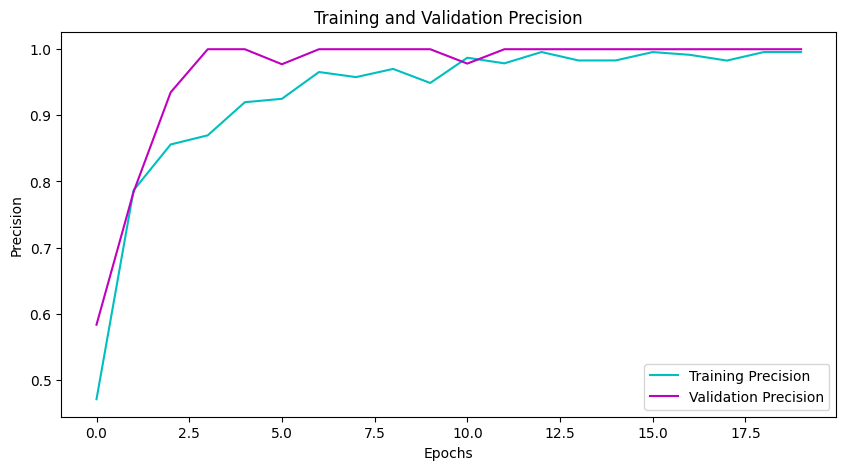

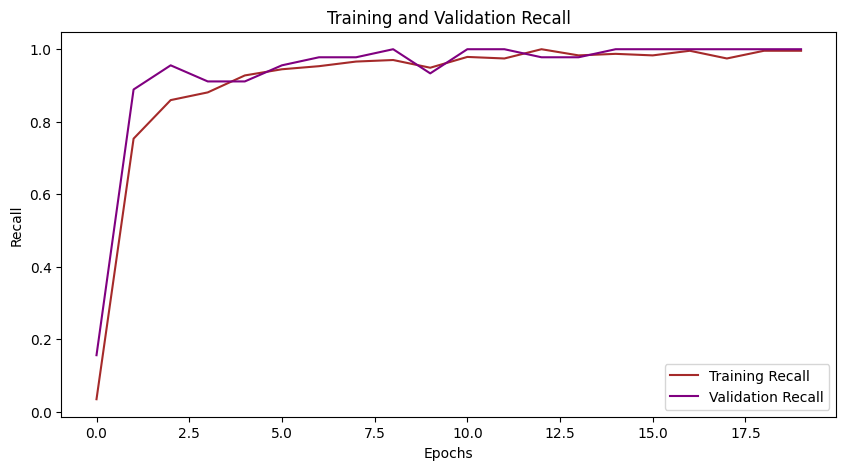

In [34]:
# Function to plot performance_score, loss, precision, and recall
def plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, precision, 'c', label='Training Precision')
    plt.plot(epochs, val_precision, 'm', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(loc=0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, recall, 'brown', label='Training Recall')
    plt.plot(epochs, val_recall, 'purple', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(loc=0)
    plt.show()


# Extracting history values
classifier_history = history.history

acc = classifier_history['performance_score']
val_acc = classifier_history['val_performance_score']
loss = classifier_history['loss']
val_loss = classifier_history['val_loss']
precision = classifier_history['precision_1']
val_precision = classifier_history['val_precision_1']
recall = classifier_history['recall_1']
val_recall = classifier_history['val_recall_1']

epochs = history.epoch

# Call the updated function
plot_metrics(acc, val_acc, loss, val_loss, precision, val_precision, recall, val_recall, epochs)


In [ ]:
convlstm_classifier.save('convLSTM_shoplifting_classifier_modified.h5')

In [36]:
classifier = load_classifier('convLSTM_shoplifting_classifier_modified.h5', compile= False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 943ms/step


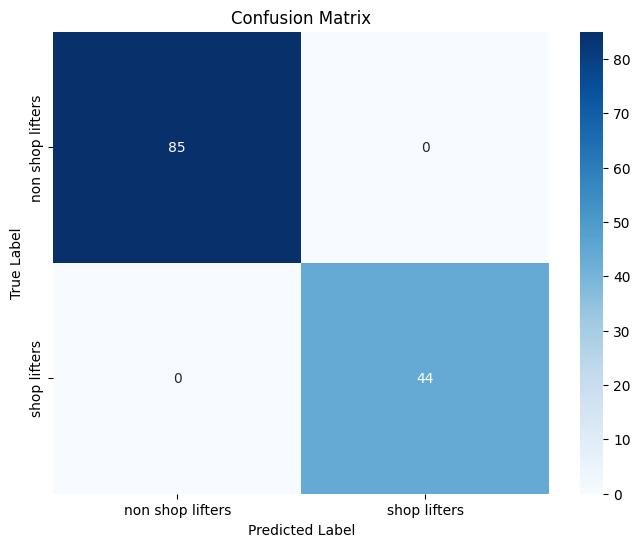

                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        85
    shop lifters       1.00      1.00      1.00        44

        accuracy                           1.00       129
       macro avg       1.00      1.00      1.00       129
    weighted avg       1.00      1.00      1.00       129



In [37]:
# Get true labels and output_predictions
y_pred_probs = classifier.predict(test_features)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification
y_true = test_labels  # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["non shop lifters", "shop lifters"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
